Sarah THOUMYRE

# Inflation Beta Strategies in European FX Markets

This project is inspired by the [Dallas Fed (2024)](https://www.dallasfed.org/research/economics/2024/0903) study, which examines how the link between inflation shocks and exchange rate movements has evolved after COVID.
The paper shows that after 2020, currencies became more sensitive to inflation changes, especially in economies with credible central banks.

In particular (and what we aim to verify), the Dallas Fed shows that:

- The FX–inflation relationship differs between developed and emerging markets: developed currencies usually appreciate after inflation shocks (positive or negative), while emerging ones often depreciate due to lower monetary policy credibility.
- There was a post-COVID strengthening of the link between inflation surprises and exchange rate movements, reflecting the renewed influence of central bank inflation control.

Our objective is to address the following question:
***<h3 align="center">To what extent do inflation changes create exploitable allocation signals in European FX markets?</h3>***

Our goal is to check whether monthly inflation changes contain a stable enough pattern to build simple, systematic FX signals through a transparent linear approach.

### Our Assumptions

1. **Geographical Scope**: We restrict our analysis to the main European currencies, distinguishing between:
      - **Developed economies**: Euro Area, United Kingdom, Switzerland, Sweden, Norway  
      - **Emerging economies:** Poland, Hungary  
<br>

2. **Inflation Measure**: We measure inflation changes using monthly changes in year-over-year CPI (ΔYoY CPI).
   To make countries comparable, we standardize these changes (z-scores).

   This approach is different from the Dallas Fed, which uses forecast-based surprises (actual CPI minus Bloomberg expectations).
<br>

3. **Exchange Rate Convention**: All FX rates are expressed in USD-based form (e.g., USDEUR, USDGBP), in line with the Dallas Fed’s methodology. This ensures comparability across markets and isolates domestic currency reactions to global USD movements.
<br>

4. **Frequency and Horizon**: We use monthly data over 2015–2025, which allows us to analyse the FX–inflation link at two levels:
      - **10-year horizon**: We study co-movements between inflation and FX across the full decade to    identify structural patterns and regime shifts.
      - **Month-to-month horizon**: We analyse how FX returns react to monthly standardized inflation variations.
<br>
<br>

5. **Modeling Framework**: We approximate the FX–inflation relationship using a linear regression framework. Each currency’s monthly return is regressed on its domestic standardized inflation shock and U.S. inflation, which captures global effects.

   This linear assumption is the strongest simplification in our study, and it comes with limits : it ignores intraday reactions, forecast-based surprises, non-linear behaviours, and regime switches.
   Still, it offers several advantages:
      - **Interpretability**: The estimated betas provide a direct and transparent measure of how currencies move with inflation.
      - **Comparability**: Standardized changes allow us to compare sensitivities across countries in a consistent way.
      - **Stability**: Using both OLS and regularized models (Ridge, Lasso, ElasticNet) helps control overfitting and highlights persistent patterns.

   While the true FX–inflation relationship is more complex, this framework still helps capture the main month-to-month patterns.

   Thus, the core objective of this study is to evaluate how far this simplified framework can capture inflation-driven FX dynamics, and to understand the boundaries of what it can and cannot explain.

### Reference

Davis, J. S., & Sagnanert, P. (2024). *Impact of inflation shocks on foreign exchange rates reflects central bank stature*.  
Federal Reserve Bank of Dallas.  
Available at: https://www.dallasfed.org/research/economics/2024/0903

### Required Packages

**pip version:** 24.2

- pandas  
- numpy  
- matplotlib  
- seaborn  
- fredapi
- requests

- skfin : skfin.plot (line), skfin.metrics (sharpe_ratio), skfin.mv_estimators (MeanVariance), skfin.estimators (LinearRegression)

- scikit-learn: RidgeCV, LassoCV, ElasticNetCV, StandardScaler, make_pipeline


In [1]:
#To install the packages if needed, run the following command:
#!pip install pandas numpy matplotlib seaborn scikit-learn fredapi requests skfin

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from skfin.plot import line
from skfin.metrics import sharpe_ratio
from skfin.mv_estimators import MeanVariance
from skfin.estimators import LinearRegression

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


## **PART 1 : Data Loading and Cleaning**


This section centralizes the collection and cleaning of macroeconomic data from **FRED** (with `fredapi`) and **ECB** (`https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist.zip`):


- **CPI** : converted to year-over-year (%) changes to measure inflation trends.  
- **FX** : USD-based pairs from FRED; missing currencies (PLN, HUF) completed with ECB data.  

All datasets are aggregated to a monthly frequency and aligned on a common intersection of dates (from 2015-02-28 to 2025-09-30)


In [3]:
%%writefile data_loader.py
import pandas as pd
import requests, io, zipfile, ssl
from fredapi import Fred

class DataLoader:

    def __init__(self, api_key):
        self.fred = Fred(api_key=api_key)

    def _get(self, series_dict, freq="ME", yoy=True):
        """Function to download and clean datasets from FRED and ECB."""
        data = {k: self.fred.get_series(v) for k, v in series_dict.items()}
        df = pd.DataFrame(data).resample(freq).last()
        df = df.ffill()
        if yoy:
            df = df.pct_change(12) * 100  

        df = df.dropna(how="any")
        return df

    def load_cpi(self):
        """Load CPI (YoY %) for all countries."""
        codes = {
            "EuroArea": "CP0000EZ19M086NEST",
            "UK": "GBRCPIALLMINMEI",
            "Switzerland": "CHNCPIALLMINMEI",
            "Sweden": "SWECPIALLMINMEI",
            "Norway": "NORCPIALLMINMEI",
            "Poland": "POLCPIALLMINMEI",
            "Hungary": "HUNCPIALLMINMEI",
            "US": "USACPIALLMINMEI"
        }
        return self._get(codes, "ME", yoy=True)

    def load_fx(self):
        """Load FX pairs – all expressed versus USD (USD-based convention)."""

        ssl._create_default_https_context = ssl._create_unverified_context

        def safe_get(series_id):
            try:
                return self.fred.get_series(series_id)
            except Exception as e:
                print(f"Skipping {series_id} — {type(e).__name__}: {e}")
                return None

        fred_codes = {
            "EURUSD": "DEXUSEU",   # USD per EUR 
            "USDGBP": "DEXUSUK",   # GBP per USD 
            "USDCHF": "DEXSZUS",   # CHF per USD 
            "USDSEK": "DEXSDUS",   # SEK per USD
            "USDNOK": "DEXNOUS",   # NOK per USD
        }

        fx_data = {}

        for name, code in fred_codes.items():
            try:
                data = safe_get(code)
                if data is not None and not data.empty:
                    fx_data[name] = data
            except Exception as e:
                print(f"Could not load Fred data — {type(e).__name__}: {e}")
                continue

        fx = pd.DataFrame(fx_data).resample("B").last().ffill()

        # Convert EURUSD to USD-based (currently USD per EUR)
        if "EURUSD" in fx.columns:
            fx["USDEUR"] = 1 / fx["EURUSD"]
            fx = fx.drop(columns=["EURUSD"])

        fx = fx.sort_index().dropna(how="any")

        # Add PLN & HUF via ECB data
        try:
            url = "https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist.zip"
            r = requests.get(url)
            with zipfile.ZipFile(io.BytesIO(r.content)) as z:
                with z.open("eurofxref-hist.csv") as f:
                    ecb = pd.read_csv(f)

            ecb["Date"] = pd.to_datetime(ecb["Date"], errors="coerce")
            ecb = (
                ecb.set_index("Date")[["PLN", "HUF"]]
                .rename(columns={"PLN": "EURPLN", "HUF": "EURHUF"})
                .sort_index()
                .ffill()
            )

            # Convert to USD-based using USDEUR
            if "USDEUR" in fx.columns:
                for col in ["EURPLN", "EURHUF"]:
                    if col in ecb.columns:
                        fx[f"USD{col[-3:]}"] = fx["USDEUR"] * ecb[col]

        except Exception as e:
            print(f"Could not load ECB PLN/HUF data — {type(e).__name__}: {e}")

        fx = fx.sort_index().dropna(how='any')

        if "USDEUR" in fx.columns:
            cols = ["USDEUR"] + [c for c in fx.columns if c != "USDEUR"]
            fx = fx[cols]
        
        fx = fx.resample("ME").last()

        return fx

    # All data combined
    def load_all(self):
        """Load all datasets, align them on a common time range, and clean."""
        data = {
            "cpi": self.load_cpi(),
            "fx": self.load_fx()
        }

        start_filter = "2015-01-01"
        end_filter = "2025-12-31"
        aligned = {k: v.loc[start_filter:end_filter] for k, v in data.items()}

        print(f"Datasets loaded: {list(aligned.keys())}")
        return aligned

Overwriting data_loader.py


In [4]:
from data_loader import DataLoader
loader = DataLoader(api_key="6345497de3d7a8897a4c41249b318253")
datasets = loader.load_all()

cpi = datasets["cpi"]
fx = datasets["fx"]

Datasets loaded: ['cpi', 'fx']


**Computation of key variables for the inflation–FX analysis:** 

- **FX monthly returns (%):** percentage change of each USD-based exchange rate.  
- **Inflation changes:** monthly change in YoY CPI.

In [5]:
fx_ret = fx.pct_change() * 100

infl_change = cpi.diff()

# Merge and clean
df = pd.concat([fx_ret, infl_change], axis=1).dropna()
df.columns = [c.replace("_", "") for c in df.columns]
display(df.head())

,USDEUR,USDGBP,USDCHF,USDSEK,USDNOK,USDPLN,USDHUF,EuroArea,UK,Switzerland,Sweden,Norway,Poland,Hungary,US
2015-02-28,0.830580,2.748569,3.289902,0.994778,-1.134223,-0.489864,-2.077715,0.314526,-0.102953,0.702775,0.279074,-0.216634,-0.159994,0.444567,0.064222
2015-03-31,4.245415,-3.815014,2.091874,3.246963,5.082290,2.563389,3.006978,0.222565,-0.101518,-0.094256,0.089555,0.098965,0.081421,0.370985,-0.048508
2015-04-30,-3.771725,3.218855,-3.109555,-2.886354,-6.002757,-5.194398,-2.685490,0.279490,-0.000910,0.209036,-0.395703,-0.007995,0.401929,0.295250,-0.125879
2015-05-31,1.528106,-0.274008,-0.063762,1.751056,2.860729,4.171621,3.570001,0.389802,0.200803,-0.306742,0.293160,0.100261,0.079804,0.885034,0.159662
2015-06-30,-1.434463,2.884993,-0.616759,-2.707490,0.936476,0.028578,0.489623,-0.100438,-0.201407,0.103076,-0.495932,0.621677,0.000000,0.073346,0.163559


**Computation of the inflation signal : z-score of ΔYoY CPI**

In [6]:
# Map each USD-based FX to its domestic inflation series
mapping = {
    "USDEUR": "EuroArea",
    "USDGBP": "UK",
    "USDCHF": "Switzerland",
    "USDSEK": "Sweden",
    "USDNOK": "Norway",
    "USDPLN": "Poland",
    "USDHUF": "Hungary",
}

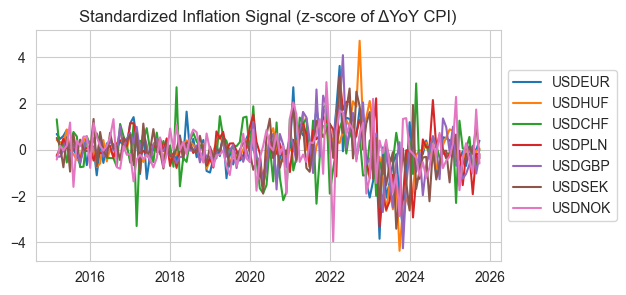

In [7]:
infl_signal_global = pd.DataFrame(index=infl_change.index)

for fx, country in mapping.items():
    if country in infl_change.columns:
        infl_signal_global[fx] = (
            (infl_change[country] - infl_change[country].mean()) /
            infl_change[country].std()
        )

infl_signal_global = infl_signal_global.dropna()
line(
    infl_signal_global,
    title="Standardized Inflation Signal (z-score of ΔYoY CPI)",
    legend=True,
    figsize=(6, 3)
)


## **PART 2 : Exploratory Analysis** 

Our objective in this section is to examine, using a dataset based on standardized CPI monthly changes (rather than Bloomberg-based inflation surprises), whether we still observe the two patterns highlighted by the Dallas Fed:
1. The FX–inflation relationship differs between developed and emerging markets.
2. This relationship has strengthened since the COVID period.

In this section, we take a 10-year perspective. We focus on broad trends and structural differences across countries.

The goal of this part is also to go beyond the correlations studied by the Dallas Fed, by linking inflation sensitivity to FX returns, and by examining how the risk–return profile of European currencies changed after COVID.

### FX–Inflation Correlations


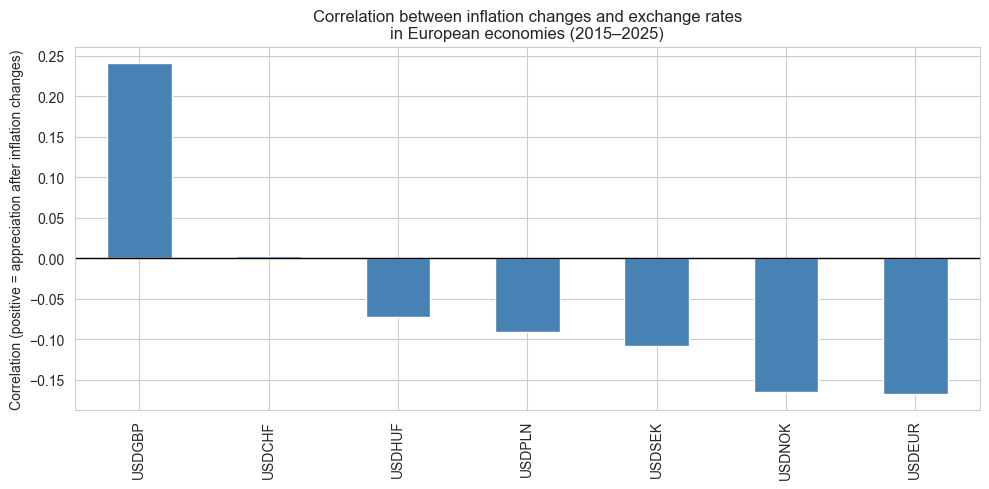

In [8]:
corrs = {}
for fx, infl in mapping.items():
    if fx in df.columns and infl in df.columns:
        corrs[fx] = -df[fx].corr(df[infl])

corr_series = pd.Series(corrs).sort_values(ascending=False)

plt.figure(figsize=(10,5))
corr_series.plot(kind="bar", color="steelblue")
plt.title("Correlation between inflation changes and exchange rates\nin European economies (2015–2025)")
plt.ylabel("Correlation (positive = appreciation after inflation changes)")
plt.axhline(0, color="black", lw=1)
plt.tight_layout()
plt.show()


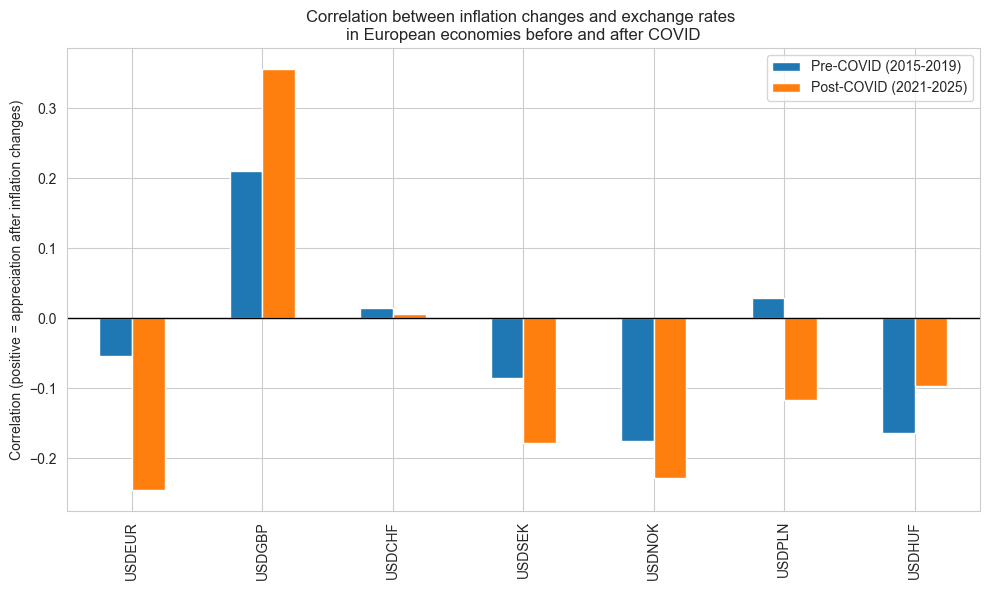

In [9]:
pre_covid = df.loc["2015":"2019"]
post_covid = df.loc["2021":"2025"]

corr_pre, corr_post = {}, {}

for fx, infl in mapping.items():
    if fx in df.columns and infl in df.columns:
        corr_pre[fx] = -pre_covid[fx].corr(pre_covid[infl])
        corr_post[fx] = -post_covid[fx].corr(post_covid[infl])

corr_df = pd.DataFrame({"Pre-COVID (2015-2019)": corr_pre, "Post-COVID (2021-2025)": corr_post})

corr_df.plot(kind="bar", figsize=(10,6))
plt.title("Correlation between inflation changes and exchange rates \nin European economies before and after COVID")
plt.ylabel("Correlation (positive = appreciation after inflation changes)")
plt.axhline(0, color="black", lw=1)
plt.legend()
plt.tight_layout()
plt.show()


***Interpretation of results***

**1. Developed vs emerging markets**

- **Consistent with Dallas Fed findings:**  
  - **GBP (positive correlation):** confirms that the pound appreciates after inflation changes, consistent with strong policy credibility. 
  - **CHF (low positive correlation)**: the link exists but remains limited. It is consistent with the franc’s safe-haven profile, which makes it less sensitive to domestic inflation variations.   
  - **HUF, PLN (negative correlations):** consistent with the idea that inflation changes lead to depreciation in emerging markets due to weaker policy credibility.


- **Not fully consistent:**  
  - **EUR, SEK, NOK (negative correlations):** may reflect external drivers (energy prices, risk sentiment) overshadowing monetary credibility.  

**2. Post-COVID strengthening of the FX–inflation link**

The absolute correlations generally increased after 2020 (notably GBP, EUR, SEK, NOK), in line with the Dallas Fed’s findings.




### Structural Change in FX–Inflation Correlations

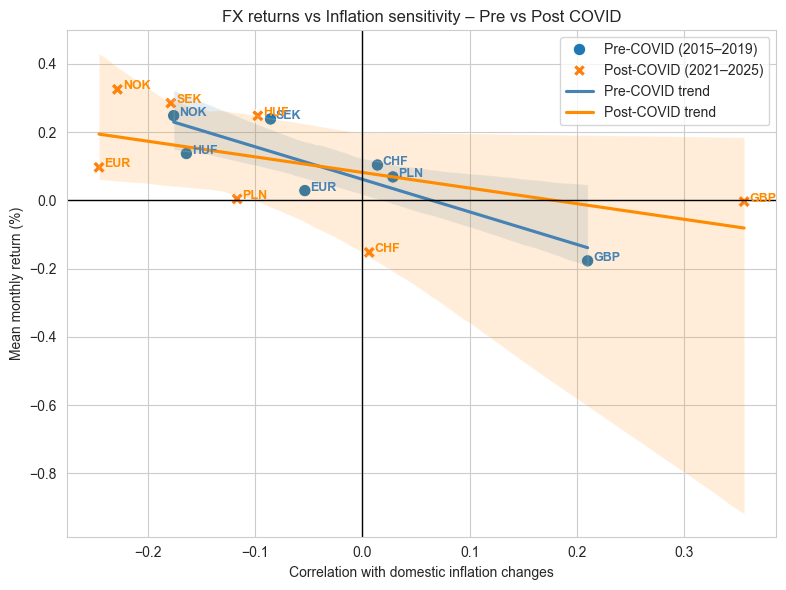

In [10]:
def compute_corrs(data):
    corrs = {}
    for fx, infl in mapping.items():
        if fx in data.columns and infl in data.columns:
            corrs[fx] = -data[fx].corr(data[infl])
    return pd.Series(corrs)

corrs_pre  = compute_corrs(pre_covid)
corrs_post = compute_corrs(post_covid)

mean_ret_pre  = pre_covid[mapping.keys()].mean()
mean_ret_post = post_covid[mapping.keys()].mean()

scatter_pre = pd.DataFrame({
    "FX": corrs_pre.index,
    "Inflation_sensitivity": corrs_pre.values,
    "Mean_return": mean_ret_pre.values,
    "Period": "Pre-COVID (2015–2019)"
}).dropna()

scatter_post = pd.DataFrame({
    "FX": corrs_post.index,
    "Inflation_sensitivity": corrs_post.values,
    "Mean_return": mean_ret_post.values,
    "Period": "Post-COVID (2021–2025)"
}).dropna()

scatter_df = pd.concat([scatter_pre, scatter_post])

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=scatter_df,
    x="Inflation_sensitivity", y="Mean_return",
    hue="Period", style="Period", s=80
)
sns.regplot(data=scatter_pre, x="Inflation_sensitivity", y="Mean_return",
            scatter=False, color="steelblue", label="Pre-COVID trend")
sns.regplot(data=scatter_post, x="Inflation_sensitivity", y="Mean_return",
            scatter=False, color="darkorange", label="Post-COVID trend")

for _, row in scatter_pre.iterrows():
    plt.text(row["Inflation_sensitivity"] + 0.005, row["Mean_return"], 
             row["FX"][-3:], color="steelblue", fontsize=9, weight="bold")

for _, row in scatter_post.iterrows():
    plt.text(row["Inflation_sensitivity"] + 0.005, row["Mean_return"], 
             row["FX"][-3:], color="darkorange", fontsize=9, weight="bold")


plt.title("FX returns vs Inflation sensitivity – Pre vs Post COVID")
plt.xlabel("Correlation with domestic inflation changes")
plt.ylabel("Mean monthly return (%)")
plt.axhline(0, color="black", lw=1)
plt.axvline(0, color="black", lw=1)
plt.legend()
plt.tight_layout()
plt.show()


***Interpretation of results***

This graph links inflation sensitivity to average FX return. 
It shows that higher inflation sensitivity did not systematically lead to better FX performance. This indicates that in European currencies, post-COVID dynamics were increasingly influenced by external factors rather than by monetary credibility alone. This result diverges from the Dallas Fed conclusion.

### Evolution of the Mean–Variance Frontier 

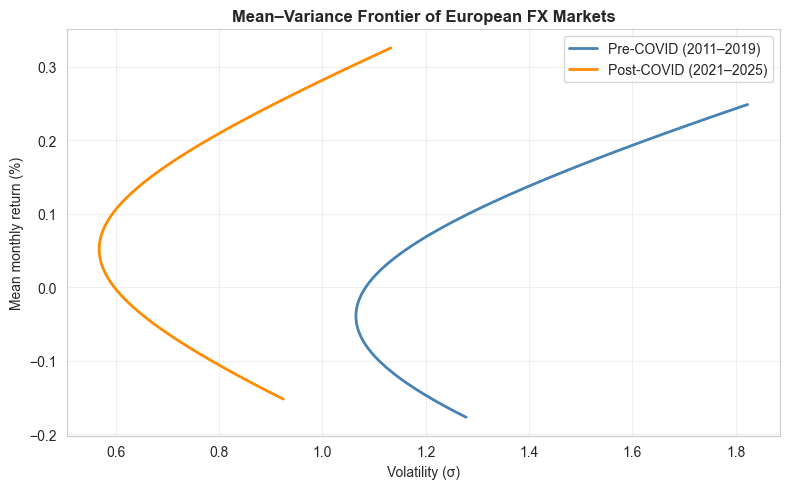

In [11]:
def mean_variance_frontier(data, fx_cols, label, color):
    """
    Compute and plot the efficient frontier using the MeanVariance estimator
    """
    mu = data[fx_cols].mean().values
    V = data[fx_cols].cov().values

    mv = MeanVariance(risk_target=1.0)
    mv.fit(None, data[fx_cols].values)

    invV = np.linalg.inv(mv.V_)
    ones = np.ones(len(mu))

    A = ones.T @ invV @ ones
    B = ones.T @ invV @ mu
    C = mu.T @ invV @ mu
    D = A * C - B**2

    target_returns = np.linspace(mu.min(), mu.max(), 100)
    frontier = []

    for r in target_returns:
        w = invV @ ((C - B * r) * ones + (A * r - B) * mu) / D
        port_var = w.T @ V @ w
        port_ret = np.dot(w, mu)
        frontier.append((np.sqrt(port_var), port_ret))

    frontier = np.array(frontier)
    plt.plot(frontier[:, 0], frontier[:, 1], color=color, lw=2, label=label)


fx_cols = list(mapping.keys())

plt.figure(figsize=(8, 5))
mean_variance_frontier(pre_covid, fx_cols, "Pre-COVID (2011–2019)", "steelblue")
mean_variance_frontier(post_covid, fx_cols, "Post-COVID (2021–2025)", "darkorange")

plt.title("Mean–Variance Frontier of European FX Markets", fontsize=12, weight="bold")
plt.xlabel("Volatility (σ)")
plt.ylabel("Mean monthly return (%)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


***Interpretation of results***

This chart adds a portfolio perspective by comparing the mean–variance frontiers of European FX markets before and after COVID. It shows that post-COVID, currencies offered higher average returns for lower levels of volatility (a shift of the efficient frontier to the left). This suggests an improvement in the risk–return trade-off. Unlike the previous charts, which focus on bilateral reactions to inflation, this figure highlights how the overall investment opportunity set in European FX evolved, indicating that the post-COVID environment became more favorable to FX investors despite higher macro uncertainty.

***Conclusion of this exploratory analysis***

Overall, we confirm part of the Dallas Fed’s results: emerging currencies weaken after inflation changes, and the FX–inflation link is stronger after COVID. But several European currencies behave differently, and our additional analysis shows that inflation sensitivity does not necessarily improve FX performance. The post-COVID shift in Europe seems driven more by changes in the wider risk–return environment than by monetary credibility alone.

## **PART 3 : Inflation Beta Estimation – Linear Models & Regularization**

Having examined the long-horizon co-movements between inflation and FX, we now shift to month-to-month reactions, estimating inflation betas through linear and regularized models to evaluate their potential as systematic FX signals

### Methodology

We estimate, for each currency, how monthly FX returns respond to domestic inflation changes while controlling for U.S. inflation.  
For each USD-based pair, we run the following regression:
$$
r_{i,t} = \alpha_i + \beta_i^{local} \, \Delta \pi_{i,t} + \beta_i^{US} \, \Delta \pi_{US,t} + \varepsilon_{i,t}
$$

where:  
- $r_{i,t}$ : monthly return of currency *i* (in %)  
- $\Delta \pi_{i,t}$ : monthly change in domestic year-over-year CPI  
- $\Delta \pi_{US,t}$ : change in U.S. year-over-year CPI (control for global inflation changes) 
- $\beta_i^{US}$: U.S. inflation beta, capturing how currency *i* reacts to global inflation conditions and broad USD-driven macro changes 
- $\beta_i^{local}$ : **inflation beta**, measuring the sensitivity of the exchange rate to domestic inflation 

All variables are **standardized** before estimation to ensure comparability of coefficients across currencies.

### Robustness Tests

We perform different robustness checks to ensure that the estimated inflation betas are stable and interpretable:

**1. Model Robustness**:
We compare results from **OLS**, **RidgeCV**, **LassoCV**, and **ElasticNetCV** to confirm that estimated betas remain consistent across different regularization schemes.

**2. Hyperparameter Robustness**:
Each regularized model automatically selects its optimal penalty parameters (*alpha*, *l1_ratio*) through 5-fold cross-validation, ensuring adaptive model complexity and preventing overfitting.  

The range of tested hyperparameters is chosen for robustness:
- $\alpha \in [10^{-4}, 10^{1}]$ → covers both weak and strong regularization regimes.  
- $l_1$ ratios = [0.1, 0.3, 0.5, 0.7] → explore the trade-off between sparsity (Lasso-like) and stability (Ridge-like).  

**3. Sign Consistency**:
We verify whether the sign of β (indicating appreciation or depreciation) remains stable across models, confirming directional robustness.

**4. Magnitude Stability**:
We analyze the mean and standard deviation of β across models to ensure that coefficient magnitudes are not sensitive to the estimation method.

**5. Structural Stability**:
We re-estimate betas before and after COVID to test for structural breaks.

In [12]:
# --- Hyperparameters ---
alphas = np.logspace(-4, 1, 100)
l1_ratios = [0.1, 0.3, 0.5, 0.7]

# --- Fit all models with standardization (β_local only, controlling for US inflation) ---
results = {}

for fx, infl in mapping.items():
    if fx in df.columns and infl in df.columns and "US" in df.columns:
        X_ = df[[infl, "US"]].dropna().values
        y_ = df.loc[df[[infl, "US"]].dropna().index, fx].values

        # --- OLS (non standardized)
        ols = LinearRegression().fit(X_, y_)
        beta_ols = -ols.coef_[0] 

        # --- OLS (standardized)
        ols_std = make_pipeline(StandardScaler(), LinearRegression()).fit(X_, y_)
        beta_ols_std = -ols_std.named_steps["linearregression"].coef_[0]   

        # --- RidgeCV 
        ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=5)).fit(X_, y_)
        beta_ridge = -ridge.named_steps["ridgecv"].coef_[0]

        # --- LassoCV 
        lasso = make_pipeline(StandardScaler(), LassoCV(alphas=alphas, cv=5, max_iter=10000)).fit(X_, y_)
        beta_lasso = -lasso.named_steps["lassocv"].coef_[0]

        # --- ElasticNetCV 
        enet = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)).fit(X_, y_)
        beta_enet = -enet.named_steps["elasticnetcv"].coef_[0]

        # Store β_local only
        results[fx] = {
            "OLS": beta_ols,
            "OLS std": beta_ols_std,
            "RidgeCV": beta_ridge,
            "LassoCV": beta_lasso,
            "ElasticNetCV": beta_enet,
        }

coefs = pd.DataFrame(results).T.sort_index()

print("Inflation Betas (β_local only, controlling for US inflation), positive = local currency appreciates:")
display(
    coefs.round(4)
    .style
    .map(lambda v: "font-weight: bold" if v != 0 else "", subset=["ElasticNetCV"])
)


Inflation Betas (β_local only, controlling for US inflation), positive = local currency appreciates:


,OLS,OLS std,RidgeCV,LassoCV,ElasticNetCV
USDCHF,0.160700,0.086700,0.074000,0.000000,0.000000
USDEUR,-0.682700,-0.290300,-0.266800,-0.000000,-0.000000
USDGBP,1.464000,0.563300,0.519500,0.437600,0.390100
USDHUF,-0.123600,-0.118200,-0.116100,-0.000000,-0.000000
USDNOK,-1.061100,-0.554700,-0.514400,-0.210100,-0.219900
USDPLN,-0.075600,-0.057600,-0.070100,-0.000000,-0.000000
USDSEK,-0.481100,-0.255300,-0.239000,-0.000000,-0.000000


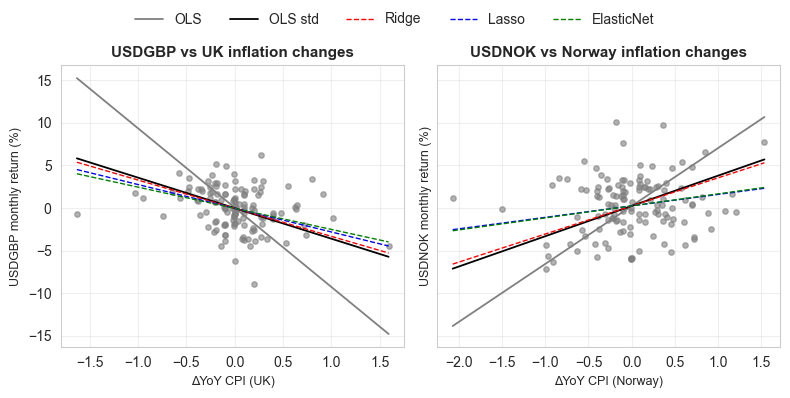

In [13]:
pairs = [
    ("USDGBP", "UK"),
    ("USDNOK", "Norway"),
]

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

for ax, (fx_pair, infl) in zip(axes, pairs):
    X_ = df[[infl]].values
    y_ = df[fx_pair].values

    beta_ols_std   = results[fx_pair]["OLS std"]
    beta_ols   = results[fx_pair]["OLS"]
    beta_ridge = results[fx_pair]["RidgeCV"]
    beta_lasso = results[fx_pair]["LassoCV"]
    beta_enet  = results[fx_pair]["ElasticNetCV"]

    x_vals = np.linspace(X_.min(), X_.max(), 100).reshape(-1, 1)
    x_scaled = (x_vals - X_.mean()) / X_.std()  
    y_mean, y_std = y_.mean(), y_.std()

    yhat_ols  = y_mean - beta_ols   * x_scaled * y_std
    yhat_ols_std   = y_mean - beta_ols_std   * x_scaled * y_std
    yhat_ridge = y_mean - beta_ridge * x_scaled * y_std
    yhat_lasso = y_mean - beta_lasso * x_scaled * y_std
    yhat_enet  = y_mean - beta_enet  * x_scaled * y_std

    ax.scatter(X_, y_, color="gray", alpha=0.6, s=15)
    ax.plot(x_vals, yhat_ols, color="gray", lw=1.3, label="OLS")
    ax.plot(x_vals, yhat_ols_std, color="black", lw=1.3, label="OLS std")
    ax.plot(x_vals, yhat_ridge, color="red", linestyle="--", lw=1, label="Ridge")
    ax.plot(x_vals, yhat_lasso, color="blue", linestyle="--", lw=1, label="Lasso")
    ax.plot(x_vals, yhat_enet, color="green", linestyle="--", lw=1, label="ElasticNet")

    ax.set_title(f"{fx_pair} vs {infl} inflation changes", fontsize=11, weight="bold")
    ax.set_xlabel(f"ΔYoY CPI ({infl})", fontsize=9)
    ax.set_ylabel(f"{fx_pair} monthly return (%)", fontsize=9)
    ax.grid(alpha=0.3)

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


***Interpretation of results***

From the regression results, **USDGBP** and **USDNOK** keep non-zero coefficients across all regularized models (Ridge, Lasso, ElasticNet).  
This persistence means their relationship with inflation changes is robust and stable, unlike other pairs where regularization shrinks the coefficients to zero, indicating weak or noisy effects.  

These 2 currencies therefore provide the clearest and most reliable signals for the next step.

In [14]:
# Sign consistency across methods
sign_consistency = (np.sign(coefs).eq(np.sign(coefs["OLS"]), axis=0)).mean() * 100

print("Sign Consistency relative to OLS (%):")
display(sign_consistency.round(1).to_frame("Consistency (%)"))

Sign Consistency relative to OLS (%):


,Consistency (%)
OLS,100.0
OLS std,100.0
RidgeCV,100.0
LassoCV,28.6
ElasticNetCV,28.6


In [15]:
# Magnitude stability across models
magnitude_stats = coefs.describe().loc[["mean", "std"]].round(3)

print("\nCoefficient Magnitude Stability (mean and std across currencies):")
display(magnitude_stats)


Coefficient Magnitude Stability (mean and std across currencies):


,OLS,OLS std,RidgeCV,LassoCV,ElasticNetCV
mean,-0.114,-0.089,-0.088,0.033,0.024
std,0.809,0.352,0.325,0.195,0.181


In [16]:
# Pre/Post-COVID Regression Split (Structural Change Test)
split_date = "2020-01-01"
df_pre = df.loc[:split_date]
df_post = df.loc[split_date:]

alphas = np.logspace(-4, 1, 100)
l1_ratios = [0.1, 0.3, 0.5, 0.7]

def estimate_betas(sub_df, mapping):
    """Return inflation betas per currency for a given sub-sample."""
    results = {}
    for fx, infl in mapping.items():
        if fx in sub_df.columns and infl in sub_df.columns and "US" in sub_df.columns:
            X_ = sub_df[[infl, "US"]].dropna().values
            y_ = sub_df.loc[sub_df[[infl, "US"]].dropna().index, fx].values

            # --- ElasticNetCV ---
            model = make_pipeline(
                StandardScaler(),
                ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)
            ).fit(X_, y_)

            results[fx] = -model.named_steps["elasticnetcv"].coef_[0]  # β_local only
    return pd.Series(results, name="Beta (ElasticNet)")


betas_pre = estimate_betas(df_pre, mapping)
betas_post = estimate_betas(df_post, mapping)

beta_compare = pd.concat([betas_pre, betas_post], axis=1)
beta_compare.columns = ["β_pre_2020", "β_post_2020"]

beta_compare["Δ|β|"] = beta_compare["β_post_2020"].abs() - beta_compare["β_pre_2020"].abs()

display(
    beta_compare.round(3)
    .style
    .background_gradient(cmap="RdBu", subset=["Δ|β|"], axis=None)
    .set_caption("Change in Inflation Sensitivity (ElasticNet) – Pre vs Post-Covid")
)


,β_pre_2020,β_post_2020,Δ|β|
USDEUR,0.000000,-0.324000,0.324000
USDGBP,0.282000,0.439000,0.157000
USDCHF,0.000000,0.000000,0.000000
USDSEK,-0.000000,-0.242000,0.242000
USDNOK,-0.115000,-0.197000,0.081000
USDPLN,0.743000,-0.000000,-0.743000
USDHUF,-0.000000,-0.000000,0.000000


***Interpretation of results***

These different models show that the inflation effect exists, but it is small and not stable across currencies. OLS and Ridge agree on the sign of the beta, while Lasso and ElasticNet keep only the strongest signals, which shows that the relationship is weak once penalties increase. Coefficient magnitudes become smaller and more stable under regularization, confirming that inflation plays a role but is not a dominant driver of monthly FX moves. The pre- vs post-Covid results also show clear shifts in betas. These robustness checks help us understand the limits of our approach and identify the situations where the inflation signal remains reliable.

## **PART 4 : Ex-post Inflation Factor Allocation Test**
 
In this part, we test whether the inflation betas we estimated contain useful economic information for FX allocation. We run a simple simulation in which currencies are weighted according to their inflation sensitivity. Our goal is to check whether these betas produce coherent patterns in portfolio returns. This exercise helps us see where the inflation signal has value and where its limits appear.
 
### Methodology
 - Positive inflation changes → overweight currencies with **β > 0** (pro-inflation).
 - Negative inflation changes → overweight currencies with **β < 0** (anti-inflation).
 
 **Implementation steps**
 1. Define static betas (from Part 3).
 2. Compute portfolio normalized weights based on the formula :  
    $$
    w_{t,i} = \frac{β_i \times signal_t}{\sum_j \left|β_j \times signal_t\right|}
    $$
    The one-month lag in portfolio weights ensures that allocations are based on available information only, avoiding look-ahead bias.
 3. Compute the simulated portfolio P&L :
    $$
    r_t^{port} = \sum_i w_{t-1,i} \cdot r_{t,i}
    $$
 4. Compare performance vs. an equal-weighted FX basket benchmark
 5. Compute performance metrics

In [17]:
# GLOBAL BENCHMARK (used for all strategies)
benchmark = fx_ret[mapping.keys()].mean(axis=1).dropna()

### Focus on the currencies with significant short-term inflation sensitivity

In this sub-section, we restrict the analysis to the 2 currencies that showed **statistically meaningful short-term betas** to inflation changes.

In [18]:
# --- 1. Define static betas and the standardized monthly inflation signal  ---
betas_enet = coefs["ElasticNetCV"].copy()
betas_enet.name = "Beta (ElasticNetCV)"

styled_betas = (
    betas_enet
    .to_frame()
    .style
    .format(lambda x: f"{x:.4f}".rstrip('0').rstrip('.') if pd.notnull(x) else "")
    .background_gradient(
        cmap="RdBu",
        vmin=-abs(betas_enet.max()),
        vmax=abs(betas_enet.max()),
        axis=None
    )
)

display(styled_betas)


,Beta (ElasticNetCV)
USDCHF,0
USDEUR,-0
USDGBP,0.3901
USDHUF,-0
USDNOK,-0.2199
USDPLN,-0
USDSEK,-0


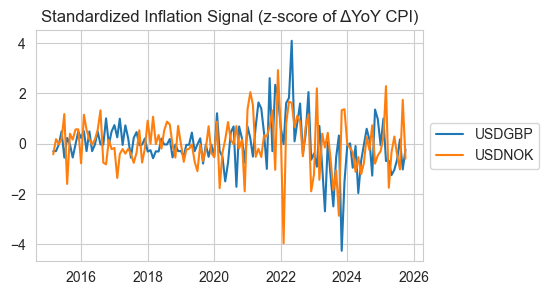

In [19]:
infl_signal = infl_signal_global.loc[df.index]

line(
    infl_signal[["USDNOK", "USDGBP"]],
    title="Standardized Inflation Signal (z-score of ΔYoY CPI)",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # légende à droite
    legend=True,
    figsize=(5, 3),
)


In [20]:
# --- 2. Compute portfolio normalized weights ---
# Compute raw weights for each date (country-level signals × betas)
w_enet = infl_signal.mul(betas_enet, axis=1)

# Normalize absolute weights to 1 across currencies (per date)
w_enet = w_enet.div(w_enet.abs().sum(axis=1), axis=0)

In [21]:
# --- 3. Compute the simulated portfolio performance ---
# Align returns and weights
fxr = fx_ret[["USDGBP", "USDNOK"]].loc[w_enet.index]
# Shift weights (use previous month allocation)
w_shifted = w_enet.shift(1).dropna()
# Compute strategy performance
pnl_enet = (w_shifted * fxr.loc[w_shifted.index]).sum(axis=1)


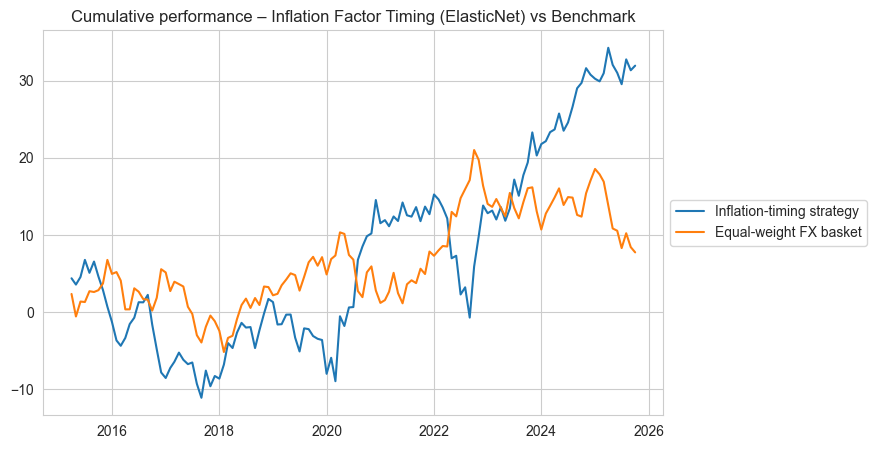

In [22]:
# --- 4. Compare cumulative performance vs. the equal-weighted FX basket benchmark ---
benchmark_aligned = benchmark.loc[pnl_enet.index]

line({
    "Inflation-timing strategy": pnl_enet.cumsum(),
    "Equal-weight FX basket": benchmark_aligned.cumsum()
}, title="Cumulative performance – Inflation Factor Timing (ElasticNet) vs Benchmark")

In [23]:
# --- 5. Compute performance metrics ---
def annualized_sharpe(x):
    return sharpe_ratio(x) * np.sqrt(12)

summary = pd.DataFrame({
    "Mean Return (%)": [pnl_enet.mean(), benchmark.mean()],
    "Volatility (%)": [pnl_enet.std(), benchmark.std()],
    "Sharpe (ann.)": [annualized_sharpe(pnl_enet), annualized_sharpe(benchmark)]
}, index=["Inflation-timing", "Equal-weight"])

display(summary.round(2))

,Mean Return (%),Volatility (%),Sharpe (ann.)
Inflation-timing,0.25,2.31,1.30
Equal-weight,0.07,1.82,0.45


### Comparison with OLS Betas

In this sub-section, we replicate the same inflation-timing methodology as before, but this time using **OLS-estimated betas** instead of those selected by the **ElasticNet**.  

In [24]:
def inflation_timing_strategy(betas, fx_ret, df):

    infl_signal = infl_signal_global.loc[df.index]
    
    # --- Compute weights = β × signal, normalized to 1 ---
    w = infl_signal.mul(betas, axis=1)
    w = w.div(w.abs().sum(axis=1), axis=0)

    # --- Compute P&L (1-month lag on weights) ---
    fxr = fx_ret[w.columns].loc[w.index]
    pnl = (w.shift(1) * fxr.loc[w.index]).sum(axis=1)
    return pnl, w


In [25]:
#Retrieve betas from regression table
betas_ols = coefs["OLS"].copy()
betas_ols_std = coefs["OLS std"].copy()

#Apply the strategy function
pnl_ols, w_ols = inflation_timing_strategy(
    betas_ols, fx_ret, df
)

pnl_ols_std, w_ols_std = inflation_timing_strategy(
    betas_ols_std, fx_ret, df
)


,Mean Return (%),Volatility (%),Sharpe (ann.)
OLS (non-std),0.03,1.80,0.21
OLS (std),0.04,1.81,0.26
ElasticNet,0.25,2.31,1.30
Equal-weight,0.07,1.82,0.45


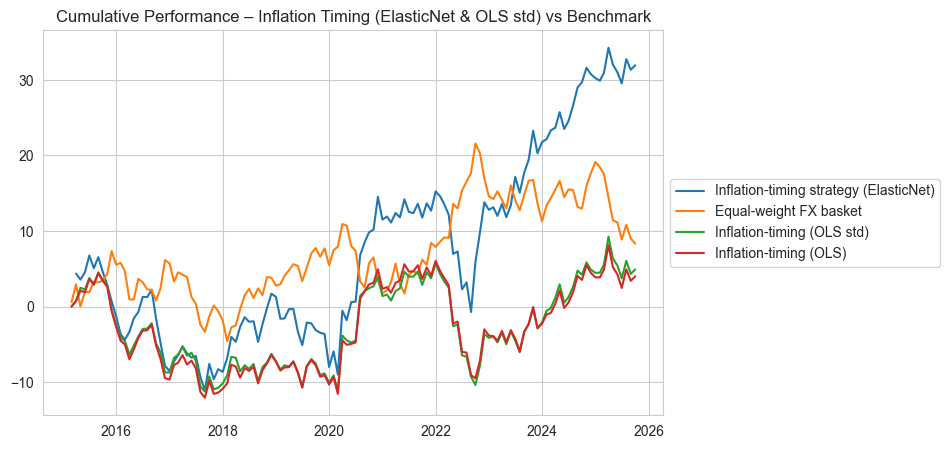

In [26]:
# --- 5. Compare cumulative performance vs. the equal-weighted FX basket benchmark ---
benchmark_aligned = benchmark.loc[pnl_ols.index]
line({
    "Inflation-timing (OLS)": pnl_ols.cumsum(), # OLS non-std
    "Inflation-timing (OLS std)": pnl_ols_std.cumsum(), # OLS std
    "Inflation-timing strategy (ElasticNet)": pnl_enet.cumsum(), # ElasticNet
    "Equal-weight FX basket": benchmark_aligned.cumsum() # Equal-weight benchmark
}, title="Cumulative Performance – Inflation Timing (ElasticNet & OLS std) vs Benchmark")

# --- Compute performance summary ---
summary = pd.DataFrame({
    "Mean Return (%)": [
        pnl_ols.mean(),         # OLS non-std
        pnl_ols_std.mean(),     # OLS std
        pnl_enet.mean(),             # ElasticNet
        benchmark.mean()        # Equal-weight benchmark
    ],
    "Volatility (%)": [
        pnl_ols.std(),
        pnl_ols_std.std(),
        pnl_enet.std(),
        benchmark.std()
    ],
    "Sharpe (ann.)": [
        annualized_sharpe(pnl_ols),
        annualized_sharpe(pnl_ols_std),
        annualized_sharpe(pnl_enet),
        annualized_sharpe(benchmark)
    ]
}, index=["OLS (non-std)", "OLS (std)", "ElasticNet", "Equal-weight"])

display(summary.round(2))


***Interpretation of results***

The allocation test shows that most inflation-timing signals have limited economic value at the monthly horizon. OLS-based strategies stay close to the equal-weight benchmark, which confirms that the inflation effect is weak and not a dominant driver of FX returns. Although the ElasticNet version performs better, this is primarily due to stronger trends in a small number of currencies rather than a general, consistent factor. We can conclude that, while inflation shocks do contain information, their capacity to produce systematic FX signals is limited and depends on the estimation technique.

**ElasticNet Inflation-Beta Strategy: Pre/Post-COVID Performance**

In [27]:
def summary_stats(pnl):
    if pnl.dropna().empty:
        return {"Mean": np.nan, "Vol": np.nan, "Sharpe": np.nan, "Positive months": np.nan}
    return {
        "Mean": pnl.mean(),
        "Vol": pnl.std(),
        "Sharpe": annualized_sharpe(pnl),
        "Positive months": (pnl > 0).mean() * 100
    }

split_date = "2020-01-01"
pnl_pre = pnl_enet.loc[:split_date]
pnl_post = pnl_enet.loc[split_date:]

stats_pre = summary_stats(pnl_pre)
stats_post = summary_stats(pnl_post)

results_df = pd.DataFrame({
    "Mean Return": [stats_pre["Mean"], stats_post["Mean"]],
    "Volatility": [stats_pre["Vol"], stats_post["Vol"]],
    "Sharpe": [stats_pre["Sharpe"], stats_post["Sharpe"]],
    "Positive Months (%)": [stats_pre["Positive months"], stats_post["Positive months"]],
}, index=["Pre-COVID (2015–2019)", "Post-COVID (2020–2025)"])

results_df.round(2)

,Mean Return,Volatility,Sharpe,Positive Months (%)
Pre-COVID (2015–2019),-0.14,1.96,-0.84,46.55
Post-COVID (2020–2025),0.58,2.54,2.74,59.42


***Interpretation of results***

We evaluate here the ElasticNet performance across regimes to check whether the inflation signal is stable over time. The results show a clear break: before 2020 the strategy is weak, while after 2020 returns and Sharpe improve sharply. This confirms that the signal is regime-dependent and works mainly in high-inflation environments, consistent with our month-to-month framework.

Since the relationship is not stable across periods, we now turn to a rolling backtest to study how inflation betas evolve dynamically over time.

## **PART 5 : Rolling Backtest – Dynamic Inflation Betas**

In this section, we evaluate whether the inflation–FX relationship remains useful when applied in a backtesting framework.

   ### Methodology

   We simulate an investor who regularly re-estimates the inflation betas and reallocates the portfolio.
   We ensure that the strategy uses only information available at the time of each allocation.
   Because inflation data releases occur on different dates within the month across countries and are sometimes delayed, we apply a one-month lag to all inflation variables.
   This prevents any look-ahead bias.

   **Implementation steps**  
   1. Prepare inputs for each iteration : inflation variables are **lagged by one month** to avoid look-ahead bias

   2. Define rolling windows (training and testing windows)

   3. Estimate betas on the training window (same logic as in Part 4) 

   4. Apply the same allocation logic as in Part 4

   ### Robustness Test

   **1. Model robustness**  
   We compare three models: OLS, standardized OLS, and ElasticNetCV.  

   **2. Hyperparameter robustness**  
   Each ElasticNet model performs internal 5-fold cross-validation to select optimal regularization parameters (*alpha*, *l1_ratio*).  
   We also vary the training and test windows lengths.

In [28]:
# Inflation variables are lagged by one month to avoid look-ahead bias.
infl_change_lagged = infl_change.shift(1)
df = pd.concat([fx_ret, infl_change_lagged], axis=1).dropna()

### 5 years training, 1 year testing

In [29]:
def run_rolling_backtest(
    df, fx_ret, benchmark, mapping,
    window_train=60, window_test=12,
    model_type="ols",   # "ols", "ols_std", "enet"
):
    dates = df.index
    results = []
    betas_all = []
    betas_index = []

    for start in range(0, len(dates) - window_train - window_test, window_test):

        train = df.iloc[start:start + window_train]
        test = df.iloc[start + window_train:start + window_train + window_test]

        # 1) BETAS ESTIMATION
        betas = {}

        for fx_pair, infl_var in mapping.items():

            if fx_pair in train.columns and infl_var in train.columns and "US" in train.columns:

                # Variables
                X_ = train[[infl_var, "US"]].dropna().values
                y_ = train.loc[train[[infl_var, "US"]].dropna().index, fx_pair].values

                # === CASE 1 : OLS ===
                if model_type == "ols":
                    model = LinearRegression().fit(X_, y_)
                    betas[fx_pair] = -model.coef_[0]

                # === CASE 2 : OLS std ===
                elif model_type == "ols_std":
                    scaler_X = StandardScaler()
                    scaler_y = StandardScaler()

                    X_scaled = scaler_X.fit_transform(X_)
                    y_scaled = scaler_y.fit_transform(y_.reshape(-1,1)).ravel()

                    model = LinearRegression().fit(X_scaled, y_scaled)
                    betas[fx_pair] = -model.coef_[0]

                # === CASE 3 : ElasticNet ===
                elif model_type == "enet":

                    scaler_X = StandardScaler()
                    X_scaled = scaler_X.fit_transform(X_)

                    model = ElasticNetCV(
                        l1_ratio=0.5,
                        cv=5,
                        fit_intercept=True,
                        random_state=0,
                        max_iter=10000
                    ).fit(X_scaled, y_)

                    betas[fx_pair] = -model.coef_[0]

        betas = pd.Series(betas)
        betas_all.append(betas)
        betas_index.append(train.index[-1])

        # 2) SIGNAL INFLATION
        infl_signal = pd.DataFrame(index=test.index)

        for fx_pair, infl_var in mapping.items():
            if infl_var in test.columns:
                signal = (test[infl_var] - test[infl_var].mean()) / test[infl_var].std()
                infl_signal[fx_pair] = signal

        # 3) WEIGHTS
        w = infl_signal.mul(betas, axis=1)
        w = w.div(w.abs().sum(axis=1), axis=0)

        # 4) P&L
        fxr = fx_ret[w.columns].loc[w.index]
        pnl = (w.shift(1) * fxr).sum(axis=1)

        results.append(pnl)

    pnl_rolling = pd.concat(results).sort_index()
    benchmark_aligned = benchmark.loc[pnl_rolling.index]

    betas_df = pd.DataFrame(betas_all, index=pd.to_datetime(betas_index))
    betas_df.index = betas_df.index.date
    betas_df.index.name = "Date"

    return pnl_rolling, benchmark_aligned, betas_df


In [30]:
pnl_rolling, benchmark_aligned, betas_df_ols = run_rolling_backtest(
    df, fx_ret, benchmark, mapping,
    model_type="ols"
)
pnl_rolling_std, benchmark_aligned, betas_df_ols_std = run_rolling_backtest(
    df, fx_ret, benchmark, mapping,
    model_type="ols_std"
)
pnl_rolling_enet, benchmark_aligned, betas_df_enet = run_rolling_backtest(
    df, fx_ret, benchmark, mapping,
    model_type="enet"
)

styled_betas = (
    betas_df_ols
    .style
    .format(lambda x: f"{x:.2f}".rstrip('0').rstrip('.') if pd.notnull(x) else "")
    .background_gradient(
        cmap="RdBu",
        axis=None,
        vmin=-abs(betas_df_ols.max().max()),
        vmax=abs(betas_df_ols.max().max())
    )
)

print("\nRolling Betas (OLS):")
display(styled_betas)

styled_betas = (
    betas_df_ols_std
    .style
    .format(lambda x: f"{x:.2f}".rstrip('0').rstrip('.') if pd.notnull(x) else "")
    .background_gradient(
        cmap="RdBu",
        axis=None,
        vmin=-abs(betas_df_ols.max().max()),
        vmax=abs(betas_df_ols.max().max())
    )
)

print("\nRolling Betas (OLS std):")
display(styled_betas)

styled_betas = (
    betas_df_enet
    .style
    .format(lambda x: f"{x:.2f}".rstrip('0').rstrip('.') if pd.notnull(x) else "")
    .background_gradient(
        cmap="RdBu",
        axis=None,
        vmin=-abs(betas_df_ols.max().max()),
        vmax=abs(betas_df_ols.max().max())
    )
)

print("\nRolling Betas (ElasticNet):")
display(styled_betas)



Rolling Betas (OLS):


,USDEUR,USDGBP,USDCHF,USDSEK,USDNOK,USDPLN,USDHUF
Date,,,,,,,
2020-02-29,-0.97,1.64,0.14,2.21,0.45,-0.92,-2.05
2021-02-28,-0.13,-0.62,-0.22,1.4,0.9,-0.98,-1.42
2022-02-28,-0.68,0.2,-0,0.7,1.02,-1.14,-1.72
2023-02-28,-0.95,0.1,-0.39,-0.67,0.68,-0.85,0.39
2024-02-29,-1.02,0.21,-0.28,-0.2,1.24,-0.46,0.17



Rolling Betas (OLS std):


,USDEUR,USDGBP,USDCHF,USDSEK,USDNOK,USDPLN,USDHUF
Date,,,,,,,
2020-02-29,-0.13,0.1,0.03,0.24,0.05,-0.11,-0.32
2021-02-28,-0.02,-0.05,-0.07,0.17,0.1,-0.14,-0.22
2022-02-28,-0.13,0.03,-0,0.1,0.16,-0.19,-0.28
2023-02-28,-0.22,0.02,-0.12,-0.13,0.11,-0.18,0.1
2024-02-29,-0.28,0.04,-0.08,-0.05,0.2,-0.14,0.07



Rolling Betas (ElasticNet):


,USDEUR,USDGBP,USDCHF,USDSEK,USDNOK,USDPLN,USDHUF
Date,,,,,,,
2020-02-29,-0,0.2,0,0.5,0.09,-0,-0.71
2021-02-28,-0,-0,-0,0.35,0.29,-0.22,-0.37
2022-02-28,-0,0,0,0,0.39,-0,-0.3
2023-02-28,-0.07,0,-0,-0.29,0,-0,0
2024-02-29,-0.45,0,-0,-0,0.53,-0.3,0


,Mean Return (%),Volatility (%),Sharpe (ann.)
Equal-weight benchmark,0.07,1.82,0.45
Rolling Inflation-timing (OLS non-std),0.18,1.72,1.34
Rolling Inflation-timing (OLS std),0.14,1.67,1.02
Rolling Inflation-timing (ElasticNet),0.44,2.53,2.19


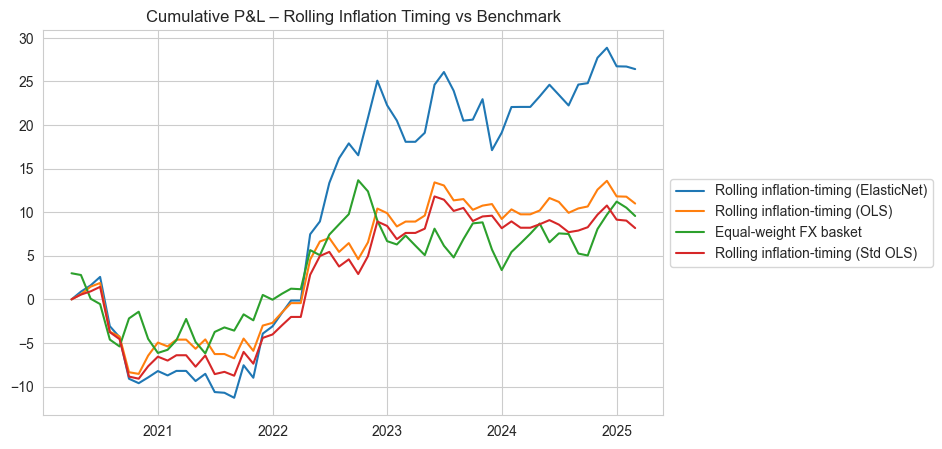

In [31]:
# Cumulative P&L chart
line({
    "Equal-weight FX basket": benchmark_aligned.cumsum(),
    "Rolling inflation-timing (OLS)": pnl_rolling.cumsum(),
    "Rolling inflation-timing (Std OLS)": pnl_rolling_std.cumsum(),
    "Rolling inflation-timing (ElasticNet)": pnl_rolling_enet.cumsum()
}, title="Cumulative P&L – Rolling Inflation Timing vs Benchmark")


summary_comparison = pd.DataFrame({
    "Mean Return (%)": [
        benchmark.mean(),
        pnl_rolling.mean(),             # OLS
        pnl_rolling_std.mean(),         # Standardized OLS
        pnl_rolling_enet.mean()         # ElasticNet
    ],
    "Volatility (%)": [
        benchmark.std(),
        pnl_rolling.std(),
        pnl_rolling_std.std(),
        pnl_rolling_enet.std()
    ],
    "Sharpe (ann.)": [
        annualized_sharpe(benchmark),
        annualized_sharpe(pnl_rolling),
        annualized_sharpe(pnl_rolling_std),
        annualized_sharpe(pnl_rolling_enet)
    ]
}, index=[
    "Equal-weight benchmark",
    "Rolling Inflation-timing (OLS non-std)",
    "Rolling Inflation-timing (OLS std)",
    "Rolling Inflation-timing (ElasticNet)"
])

summary_comparison = summary_comparison.round(2)

display(summary_comparison)

***Interpretation of results***

With a 5-year training and a 1-year testing windows, the rolling backtest shows that updating inflation betas over time improves the behaviour of the signal. OLS versions deliver small but consistent gains over the equal-weight benchmark, and they do so with slightly lower risk.

ElasticNet has the highest Sharpe ratio but with higher volatility, meaning that the strategy captures strong inflation-driven trends but also takes on more risk. This confirms that the inflation–FX link is not stable, depends on the macro regime, and that its usefulness varies with the trade-off between return and risk.

Because this behaviour depends on the chosen window length, we now test different rolling windows to find the one that has the highest Sharpe ratio.

### Sharpe Ratio Grid Search – Train/Test Window Matrix

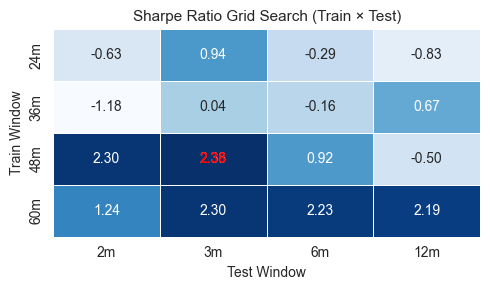

In [32]:
def estimate_betas_enet(train, mapping):
    betas = {}

    for fx_pair, infl_var in mapping.items():
        if fx_pair in train.columns and infl_var in train.columns and "US" in train.columns:

            tmp = train[[infl_var, "US"]].dropna()
            if len(tmp) < 5:
                continue

            X_ = tmp.values
            y_ = train.loc[tmp.index, fx_pair].values

            scaler_X = StandardScaler()
            X_scaled = scaler_X.fit_transform(X_)

            model = ElasticNetCV(
                l1_ratio=0.5,
                cv=5,
                fit_intercept=True,
                random_state=0,
                max_iter=10000
            ).fit(X_scaled, y_)

            betas[fx_pair] = -model.coef_[0]

    return pd.Series(betas)


def compute_signal(test, mapping):
    signals = pd.DataFrame(index=test.index)

    for fx_pair, infl_var in mapping.items():
        if infl_var in test.columns:
            s = (test[infl_var] - test[infl_var].mean()) / test[infl_var].std()
            signals[fx_pair] = s

    return signals


def backtest_once(train, test, fx_ret, mapping):
    betas = estimate_betas_enet(train, mapping)
    signals = compute_signal(test, mapping)

    # WEIGHTS
    w = signals.mul(betas, axis=1)
    w = w.div(w.abs().sum(axis=1), axis=0)

    # PNL
    fxr = fx_ret[w.columns].loc[w.index]
    pnl = (w.shift(1) * fxr).sum(axis=1)

    return pnl


# GRID SEARCH
train_windows = [24, 36, 48, 60]
test_windows  = [2, 3, 6, 12]

results = {}
sharpes = {}

for w_train, w_test in product(train_windows, test_windows):

    pnl_list = []
    dates = df.index

    for start in range(0, len(dates) - w_train - w_test, w_test):

        train = df.iloc[start:start + w_train]
        test  = df.iloc[start + w_train:start + w_train + w_test]

        pnl = backtest_once(train, test, fx_ret, mapping)
        pnl_list.append(pnl)

    pnl_full = pd.concat(pnl_list).sort_index()

    key = f"train={w_train}m_test={w_test}m"
    results[key] = pnl_full
    sharpes[key] = annualized_sharpe(pnl_full)


rows = []
for key, val in sharpes.items():
    train = key.split("_")[0].replace("train=", "")
    test  = key.split("_")[1].replace("test=", "")
    rows.append([train, test, val])

df_clean = pd.DataFrame(rows, columns=["Train", "Test", "Sharpe"])
pivot_df = df_clean.pivot(index="Train", columns="Test", values="Sharpe")


order_test  = ["2m", "3m", "6m", "12m"]
order_train = ["24m", "36m", "48m", "60m"]

pivot_df = pivot_df.reindex(index=order_train, columns=order_test)

max_val = pivot_df.max().max()
max_loc = np.where(pivot_df.values == max_val)


plt.figure(figsize=(5, 3))

ax = sns.heatmap(
    pivot_df.astype(float),
    annot=True,
    fmt=".2f",
    cmap="Blues",          
    cbar=False,           
    linewidths=0.5,
    linecolor="white"
)

i, j = max_loc[0][0], max_loc[1][0]

ax.text(
    j + 0.5,
    i + 0.5,
    f"{max_val:.2f}",
    color="red",
    fontweight="bold",
    ha="center",
    va="center",
)

plt.title("Sharpe Ratio Grid Search (Train × Test)", fontsize=11)
plt.xlabel("Test Window")
plt.ylabel("Train Window")
plt.tight_layout()
plt.show()


### 4 years training, 3 months testing

In [33]:
pnl_rolling_ols_3m, benchmark_aligned_3m, betas_df_ols_3m = run_rolling_backtest(
    df, fx_ret, benchmark, mapping,
    window_train=48, 
    window_test=3,
    model_type="ols"
)

pnl_rolling_ols_std_3m, benchmark_aligned_3m, betas_df_ols_std_3m = run_rolling_backtest(
    df, fx_ret, benchmark, mapping,
    window_train=48, 
    window_test=3,
    model_type="ols_std"
)

pnl_rolling_enet_3m, benchmark_aligned_3m, betas_df_enet_3m = run_rolling_backtest(
    df, fx_ret, benchmark, mapping,
    window_train=48, 
    window_test=3,
    model_type="enet"
)

,Mean Return (%),Volatility (%),Sharpe (ann.)
Equal-weight benchmark,0.06,1.93,0.39
Rolling Inflation-timing (OLS non-std),0.19,1.37,2.06
Rolling Inflation-timing (OLS std),0.16,1.36,1.74
Rolling Inflation-timing (ElasticNet),0.30,1.83,2.38


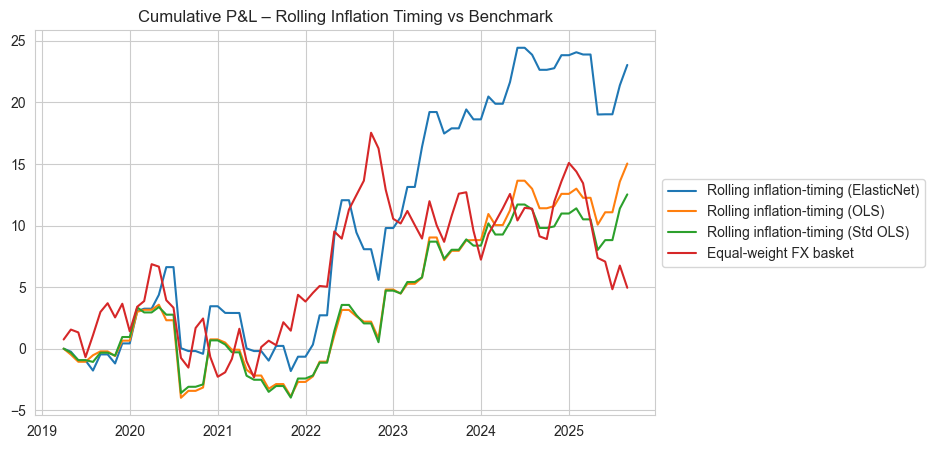

In [34]:
# Cumulative P&L chart
line({
    "Equal-weight FX basket": benchmark_aligned_3m.cumsum(),
    "Rolling inflation-timing (OLS)": pnl_rolling_ols_3m.cumsum(),
    "Rolling inflation-timing (Std OLS)": pnl_rolling_ols_std_3m.cumsum(),
    "Rolling inflation-timing (ElasticNet)": pnl_rolling_enet_3m.cumsum()
}, title="Cumulative P&L – Rolling Inflation Timing vs Benchmark")


summary_comparison_3m = pd.DataFrame({
    "Mean Return (%)": [
        benchmark_aligned_3m.mean(),
        pnl_rolling_ols_3m.mean(),         # OLS
        pnl_rolling_ols_std_3m.mean(),     # Standardized OLS
        pnl_rolling_enet_3m.mean()         # ElasticNet
    ],
    "Volatility (%)": [
        benchmark_aligned_3m.std(),
        pnl_rolling_ols_3m.std(),
        pnl_rolling_ols_std_3m.std(),
        pnl_rolling_enet_3m.std()
    ],
    "Sharpe (ann.)": [
        annualized_sharpe(benchmark_aligned_3m),
        annualized_sharpe(pnl_rolling_ols_3m),
        annualized_sharpe(pnl_rolling_ols_std_3m),
        annualized_sharpe(pnl_rolling_enet_3m)
    ]
}, index=[
    "Equal-weight benchmark",
    "Rolling Inflation-timing (OLS non-std)",
    "Rolling Inflation-timing (OLS std)",
    "Rolling Inflation-timing (ElasticNet)"
])

summary_comparison_3m = summary_comparison_3m.round(2)

display(summary_comparison_3m)


***Interpretation of results***

Overall, the 4 years/3 months configuration offers a better balance between return and risk. This result shows that a shorter training window can capture inflation-driven trends more quickly while avoiding the higher volatility seen in the longer-window setup. 

In [35]:
# ElasticNet betas (train 48m / test 3m)

styled_betas_enet_3m = (
    betas_df_enet_3m
    .style
    .format(lambda x: f"{x:.2f}".rstrip("0").rstrip(".") if pd.notnull(x) else "")
    .background_gradient(
        cmap="RdBu",
        axis=None,
        vmin=-abs(betas_df_enet_3m.max().max()),
        vmax=abs(betas_df_enet_3m.max().max())
    )
)

print("\nRolling Betas (ElasticNet) – train 48m / test 3m:")
display(styled_betas_enet_3m)


Rolling Betas (ElasticNet) – train 48m / test 3m:


,USDEUR,USDGBP,USDCHF,USDSEK,USDNOK,USDPLN,USDHUF
Date,,,,,,,
2019-02-28,-0,0,0,0.41,0,-0,-0.93
2019-05-31,-0,0.02,0,0.33,0,-0,-0.84
2019-08-31,-0.14,0.13,0,0.36,0,-0,-0.54
2019-11-30,-0.06,0.19,-0,0.02,0.08,-0,-0.53
2020-02-29,-0,0,0,0.03,0,-0,-0.37
2020-05-31,-0.06,0,-0,0.64,0.48,-0,-0.33
2020-08-31,-0,0,-0,0.73,0.09,-0.37,-0.19
2020-11-30,-0,-0,-0,0.68,0.59,-0.38,-0.2
2021-02-28,-0,-0,-0,0.15,0,-0.58,-0.43


***Interpretation of results***

What is particularly interesting here is the rolling ElasticNet betas. While the results of the full-sample correlations were sometimes contradictory, especially for EUR, SEK, and NOK (cf. Part 2), the dynamic coefficients align more closely with the mechanisms described in the Dallas Fed study.

- **Nordics (SEK, NOK)** show frequent positive coefficients. This matches the Dallas Fed pattern.

- The static correlation for **EUR** was slightly negative and hard to interpret. Here, EUR turns strongly negative after 2022. This reflects a period of energy-driven inflation and the ECB’s later response relative to other central banks. The dynamic estimation captures a regime shift that the static correlation completely masked.

- Static correlations already showed a negative emerging-market pattern for **PLN** and **HUF**, and the rolling betas confirm this clearly.

- **GBP** is often close to zero, but turns positive during periods of clear monetary tightening by the BoE (in August 2022, the BoE raised rates by 50 bps to 1.75%, which makes the positive move in GBP at that time coherent). This reflects the more volatile nature of UK inflation dynamics.

- **CHF** remains close to zero throughout the rolling estimation. This is consistent with its safe-haven status. Swiss inflation simply does not drive FX moves.

Therefore, the rolling approach reveals a coherent, time-varying inflation–FX relationship that static correlations failed to capture.

## **Conclusion**


Our study shows that, since 2015, inflation changes have influenced European FX markets, but the effect is very dependent on the macro regime. In our first long-term analysis (Part 2), we found some of the Dallas Fed’s results: emerging currencies usually weaken when inflation rises, and inflation matters more after COVID. But for many European currencies, the link was weaker and often overshadowed by other forces (which could be energy prices, growth risks, and central bank timing).

Using simple linear models, we confirm that the inflation effect exists, but it remains small. Most betas are not stable across time, and regularized models keep only a few meaningful signals. In this framework, inflation is therefore not a dominant driver of monthly FX returns.

The rolling analysis provides the clearest insights. Some currencies show consistent reactions (NOK/SEK positive, PLN/HUF negative), and EUR turns strongly negative after 2022. These patterns make economic sense and align with the idea that inflation matters more in some periods than others.

Overall, the answer to our initial question is clear: inflation changes contain useful information, but not enough to build fully systematic FX allocation signals. They help explain certain moves, especially in specific regimes or for selected currencies, but they cannot serve as a factor on its own. Within a simple linear framework, inflation is an informative but moderate and regime-dependent signal for European FX.